Using device: cuda
dat shape (neurons × trials): (39209, 5900)
Y_image_mean: (118, 39209)


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



🔍 Scanning safetensors for encoder-like matrices...
→ Using model.safetensors, key=text_model.embeddings.token_embedding.weight, shape=torch.Size([49408, 768])
✓ SAE weight ready: in_dim=768, out_dim=49408

Extracting SAE features for 118 images...


Feature extraction: 100%|██████████| 118/118 [00:05<00:00, 23.18it/s]


Raw SAE latent shape: (118, 49408)
Running TruncatedSVD → 1000 dims ...
Reduced SAE feature shape: (118, 118)

Running 5-fold SVD+CCA fits ...
Fold 1: mean_corr=0.033, skill=0.000, shuffled=0.000
Fold 2: mean_corr=0.022, skill=0.000, shuffled=-0.000
Fold 3: mean_corr=0.008, skill=-0.000, shuffled=0.000
Fold 4: mean_corr=-0.129, skill=-0.000, shuffled=-0.000
Fold 5: mean_corr=-0.067, skill=-0.000, shuffled=0.000

✅ Saved → clip_sae_vitl14_svd_cca_results.csv


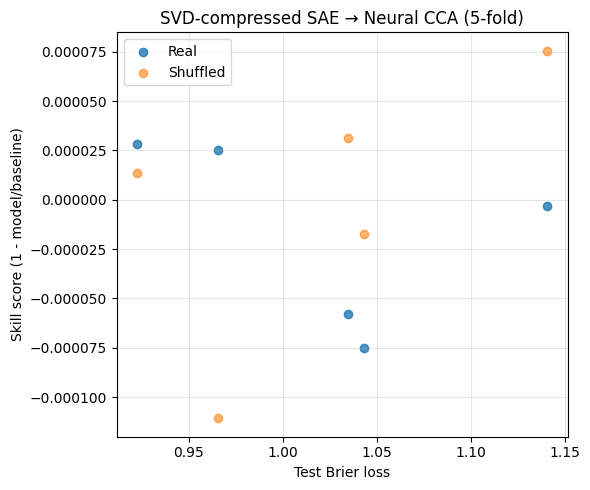

In [1]:
#!/usr/bin/env python3
# =====================================================================
# Allen Mouse Neurons — CLIP-SAE-ViT-L-14 → Neural mapping via
#                Truncated-SVD + Canonical Correlation Analysis
# =====================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from safetensors import safe_open
from huggingface_hub import snapshot_download
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)
print(f"Using device: {DEVICE}")

N_IMAGES = 118
N_TRIALS = 50
DATA_PATH = "/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
IMG_DIR = Path("/home/maria/MITNeuralComputation/vit_embeddings/images")
SAE_REPO = "zer0int/CLIP-SAE-ViT-L-14"
LOCAL_SAE_DIR = "./clip_sae_vitl14_weights"
N_CCA_COMPONENTS = 10
N_SVD_COMPONENTS = 1000   # safe compression target

# ---------------------------------------------------------------
# LOAD NEURAL DATA
# ---------------------------------------------------------------
dat = np.load(DATA_PATH)
Y_binary = (dat > 0).astype(np.float32)
n_neurons, n_samples = dat.shape
assert n_samples == N_IMAGES * N_TRIALS
img_ids_full = np.repeat(np.arange(N_IMAGES), N_TRIALS)
print(f"dat shape (neurons × trials): {dat.shape}")

Y_image_mean = np.array([Y_binary[:, img_ids_full == i].mean(axis=1)
                         for i in range(N_IMAGES)], dtype=np.float32)
print("Y_image_mean:", Y_image_mean.shape)

# ---------------------------------------------------------------
# DOWNLOAD SAE REPO (if needed)
# ---------------------------------------------------------------
snapshot_download(repo_id=SAE_REPO, local_dir=LOCAL_SAE_DIR)

# ---------------------------------------------------------------
# LOAD CLIP MODEL
# ---------------------------------------------------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# ---------------------------------------------------------------
# FIND SAE ENCODER MATRIX
# ---------------------------------------------------------------
print("\n🔍 Scanning safetensors for encoder-like matrices...")
candidates = []
for f in Path(LOCAL_SAE_DIR).glob("*.safetensors"):
    with safe_open(f, framework="pt", device="cpu") as sf:
        for k in sf.keys():
            t = sf.get_tensor(k)
            if t.ndim == 2:
                candidates.append((f, k, t.shape))
sae_path, enc_key, enc_shape = max(candidates, key=lambda x: x[2][0]*x[2][1])
print(f"→ Using {sae_path.name}, key={enc_key}, shape={enc_shape}")

with safe_open(sae_path, framework="pt", device=DEVICE) as f:
    W = f.get_tensor(enc_key)
    bias = None
    for k in f.keys():
        if "bias" in k.lower():
            b = f.get_tensor(k)
            if b.ndim == 1:
                bias = b
                break

A, B = W.shape
if A > B:
    in_dim, out_dim = B, A
    W_use = W
else:
    in_dim, out_dim = A, B
    W_use = W.T
if bias is None or bias.shape[0] != out_dim:
    bias_use = torch.zeros(out_dim, device=DEVICE)
else:
    bias_use = bias
print(f"✓ SAE weight ready: in_dim={in_dim}, out_dim={out_dim}")

# ---------------------------------------------------------------
# SAE MODULE
# ---------------------------------------------------------------
class SAEEncoder(torch.nn.Module):
    def __init__(self, in_dim, out_dim, W_init, b_init):
        super().__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)
        with torch.no_grad():
            self.linear.weight.copy_(W_init)
            self.linear.bias.copy_(b_init)
    def forward(self, x):
        return torch.relu(self.linear(x))

sae = SAEEncoder(in_dim, out_dim, W_use.to(DEVICE), bias_use.to(DEVICE)).to(DEVICE)
sae.eval()

# ---------------------------------------------------------------
# EXTRACT SAE FEATURES (float32)
# ---------------------------------------------------------------
img_paths = sorted(IMG_DIR.glob("scene_*.png"))
assert len(img_paths) == N_IMAGES
print(f"\nExtracting SAE features for {N_IMAGES} images...")

feat_fn = lambda inputs: clip_model.get_image_features(**inputs)
sae_feats = []
for p in tqdm(img_paths, desc="Feature extraction"):
    img = Image.open(p).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        x = feat_fn(inputs)
        z = sae(x)
    sae_feats.append(z.squeeze().cpu().numpy().astype(np.float32))

Z_sae = np.stack(sae_feats)
print("Raw SAE latent shape:", Z_sae.shape)

torch.cuda.empty_cache()   # free GPU RAM before CPU ops

# ---------------------------------------------------------------
# PRE-PROCESS (scaling + SVD compression)
# ---------------------------------------------------------------
scaler_x = StandardScaler(with_mean=True, with_std=True)
Z_scaled = scaler_x.fit_transform(Z_sae)

print(f"Running TruncatedSVD → {N_SVD_COMPONENTS} dims ...")
svd = TruncatedSVD(n_components=N_SVD_COMPONENTS, random_state=0)
Z_reduced = svd.fit_transform(Z_scaled)
print("Reduced SAE feature shape:", Z_reduced.shape)

scaler_y = StandardScaler(with_mean=True, with_std=True)
Y_scaled = scaler_y.fit_transform(Y_image_mean)

# ---------------------------------------------------------------
# 5-FOLD CCA
# ---------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
records = []

print("\nRunning 5-fold SVD+CCA fits ...")
for fold, (train_idx, test_idx) in enumerate(kf.split(Z_reduced), 1):
    X_train, X_test = Z_reduced[train_idx], Z_reduced[test_idx]
    Y_train, Y_test = Y_scaled[train_idx], Y_scaled[test_idx]

    cca = CCA(n_components=N_CCA_COMPONENTS, max_iter=1000)
    cca.fit(X_train, Y_train)
    Xc_test, Yc_test = cca.transform(X_test, Y_test)

    corrs = [np.corrcoef(Xc_test[:, i], Yc_test[:, i])[0, 1]
             for i in range(N_CCA_COMPONENTS)]
    mean_corr = np.nanmean(corrs)

    # Predict Y from X
    Y_pred = cca.predict(X_test)
    brier = float(np.mean((Y_pred - Y_test)**2))
    baseline = float(np.mean((Y_train.mean(axis=0) - Y_test)**2))
    skill = 1 - brier / max(baseline, 1e-12)

    # Shuffled control
    Y_train_sh, Y_test_sh = shuffle(Y_train, random_state=fold), shuffle(Y_test, random_state=fold)
    cca_sh = CCA(n_components=N_CCA_COMPONENTS, max_iter=1000)
    cca_sh.fit(X_train, Y_train_sh)
    Y_pred_sh = cca_sh.predict(X_test)
    brier_sh = float(np.mean((Y_pred_sh - Y_test_sh)**2))
    skill_sh = 1 - brier_sh / max(baseline, 1e-12)

    records.append({
        "fold": fold,
        "mean_corr": float(mean_corr),
        "Brier": brier,
        "Skill": skill,
        "Skill_shuffled": skill_sh,
    })
    print(f"Fold {fold}: mean_corr={mean_corr:.3f}, skill={skill:.3f}, shuffled={skill_sh:.3f}")

# ---------------------------------------------------------------
# SAVE + PLOT
# ---------------------------------------------------------------
df = pd.DataFrame(records)
df.to_csv("clip_sae_vitl14_svd_cca_results.csv", index=False)
print("\n✅ Saved → clip_sae_vitl14_svd_cca_results.csv")

plt.figure(figsize=(6,5))
plt.scatter(df["Brier"], df["Skill"], label="Real", alpha=0.8)
plt.scatter(df["Brier"], df["Skill_shuffled"], label="Shuffled", alpha=0.6)
plt.xlabel("Test Brier loss")
plt.ylabel("Skill score (1 - model/baseline)")
plt.title("SVD-compressed SAE → Neural CCA (5-fold)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("clip_sae_vitl14_svd_cca_results.png", dpi=200)
plt.show()


In [3]:
df

,fold,mean_corr,Brier,Skill,Skill_shuffled
0,1,0.032778,0.922432,0.000028,0.000014
1,2,0.021733,0.965547,0.000025,-0.000111
2,3,0.008071,1.140723,-0.000003,0.000076
3,4,-0.129432,1.043234,-0.000075,-0.000017
4,5,-0.067398,1.034766,-0.000058,0.000031
